# PyTorch from scratch

This uses a super-simple __linear regression__ model as the frame for walking from manually doing everything from good-old Python to using `numpy` to using `pytorch` on a GPU. It's based on this [excellent tutorial on pytorch](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)

In this interesting equation we will train a linear regression model against some synthetic data. 

$$
y = a + b x + \epsilon
$$

We will start from a plain Python program (using only the `math` library), progress to a `numpy` implementation before showing how to do the same thing using `pytorch`. The goal is to give you visibility into some of the things that different libraries abstract away for you while simultaneously ensuring that you understand what those abstractions are. We will also have some fun looking at how libraries like [sympy](https://www.sympy.org/en/index.html) can be used to help with some of the more tedious aspects of the math.

## Generating synthetic data to train against

Next, let's generate some synthetic data for an equation where `a = 1` and `b = 2`. The synthetic data will sprinkle in some Gaussian noise into the synthetic values. Let's begin by importing `numpy` and initializing the random number generator with a fixed seed value so that our results are reproducible in the future:

In [1]:
import numpy as np
np.random.seed(42)

Generate a matrix of size [100, 1] of random numbers between 0 and 1 using the [random.rand() function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.rand.html). Note that I'm using a naming convention in this notebook where variables prefixed with `d` represent __data__:

In [2]:
dx = np.random.rand(100, 1)
dx[:5]

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       [0.59865848],
       [0.15601864]])

Next, let's compute y values and sprinkle in the random noise. Marvel at the beautiful vector math and the compact notation.

In [3]:
dy = 1 + 2 * dx + .1 * np.random.randn(100, 1)
dy[:5]

array([[1.75778494],
       [2.87152788],
       [2.47316396],
       [1.99856008],
       [1.29007009]])

Generate a sequence from 0 to 99 that will represent indices into our matrix:

In [4]:
idx = np.arange(100)
idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

Now shuffle so that the indices are in a random order:

In [5]:
np.random.shuffle(idx)
idx

array([76, 83, 80, 98,  2, 77, 71, 84, 89, 50, 40, 51, 67, 86, 37, 49,  4,
       10, 69, 81,  9, 54, 55, 87, 64, 44, 90, 75, 33, 30, 93, 95, 14, 61,
       11, 13, 15,  7,  0, 19, 35,  6, 12, 65, 70, 88, 56, 58, 28, 38, 91,
       42,  8, 73, 39, 85, 25, 92, 41, 26,  1, 22, 21, 46, 74, 79, 78, 72,
       57, 53, 24, 17, 66, 32, 31, 62, 59, 52, 82, 23, 36,  5, 45, 99, 43,
       16, 48, 94, 34,  3, 18, 47, 60, 68, 63, 27, 96, 29, 20, 97])

Split the indices for the training and validation dataset such that first 80 random indices are used for training and the last 20 random indices are used for validation.

In [6]:
train_idx = idx[:80]
train_idx

array([76, 83, 80, 98,  2, 77, 71, 84, 89, 50, 40, 51, 67, 86, 37, 49,  4,
       10, 69, 81,  9, 54, 55, 87, 64, 44, 90, 75, 33, 30, 93, 95, 14, 61,
       11, 13, 15,  7,  0, 19, 35,  6, 12, 65, 70, 88, 56, 58, 28, 38, 91,
       42,  8, 73, 39, 85, 25, 92, 41, 26,  1, 22, 21, 46, 74, 79, 78, 72,
       57, 53, 24, 17, 66, 32, 31, 62, 59, 52, 82, 23])

In [7]:
val_idx = idx[80:]
val_idx

array([36,  5, 45, 99, 43, 16, 48, 94, 34,  3, 18, 47, 60, 68, 63, 27, 96,
       29, 20, 97])

Now generate the training and validation datasets. Notice how compact this is!

In [8]:
dx_train, dy_train = dx[train_idx], dy[train_idx]
dx_val, dy_val = dx[val_idx], dy[val_idx]

Now plot these two datasets side-by-side so we can see the data:

In [9]:
from bokeh.plotting import figure, show
from bokeh.layouts import row
from bokeh.io import output_notebook
output_notebook()

plot_train = figure(title="Training dataset", x_axis_label='x', y_axis_label='y', plot_height=400, plot_width=400)
plot_train.scatter(dx_train.flatten(), dy_train.flatten(), marker="square", fill_color="blue")

plot_validate = figure(title="Training dataset", x_axis_label='x', y_axis_label='y', plot_height=400, plot_width=400)
plot_validate.scatter(dx_val.flatten(), dy_val.flatten(), marker="square", fill_color="red")

show(row(plot_train, plot_validate))

Loading BokehJS ...

## Gradient descent

The loss function that we will use is the [mean square error]() loss function represented by the following equation:

$$
MSE=\frac{1}{N}\sum_{i=1}^N (y_i-\hat y_i)^2
$$

Recall that $\hat y_i$ is computed by the general linear regression equation:

$$
\hat y_i = a - b x_i
$$

which yields:

$$
MSE=\frac{1}{N}\sum_{i=1}^N (y_i - a - b x_i)^2 
$$

Next we need to compute the gradients, which are a partial derivative of each of the two variables that we are trying to learn: `a` and `b`. The following equations are computed through the application of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule):

<div id="partialderivatives">
$$
\begin{align}
\frac {\partial MSE}{\partial a} & = 
\frac {\partial MSE}{\partial \hat y_i} \cdot
\frac {\partial \hat y_i}{\partial a} \\\\ & =
\frac {1}{N} 
\sum_ {i=1}^N 2(y_i - a - b x_i) \cdot (-1) \\\\ & =
-2 \frac {1}{N} \sum_ {i=1}^N (y_i - \hat y_i) \\\\
\frac {\partial MSE}{\partial b} & = 
\frac {\partial MSE}{\partial \hat y_i} \cdot
\frac {\partial \hat y_i}{\partial b} \\\\ & =
\frac {1}{N} 
\sum_ {i=1}^N 2(y_i - a - b x_i) \cdot (-x_i) \\\\ & =
-2 \frac {1}{N} \sum_ {i=1}^N x_i (y_i - \hat y_i)
\end{align}
$$
</div>

## Using sympy to perform the same computation symbolically

We can also use `sympy` to compute the equations that we will be using for our gradients.

Let's begin by importing the `sympy` library and declaring that `a`, `b` and `N` will be scalar symbols:

In [10]:
from sympy import Sum, IndexedBase, diff, Symbol
from sympy.abc import x, y, i, a, b
N = Symbol('N')

We will declare $x_i$ and $y_i$ as __indexed__ symbols:

In [11]:
y = IndexedBase('y')
x = IndexedBase('x')

Finally, we will define the __mean square error__ equation using a combination of Python arithmetic expressions and the sympy `Sum` method to define the summation expression:

In [12]:
mse = (1/N) * Sum((y[i] - a - b * x[i]) ** 2, [i, 1, N])
mse

Sum((-a - b*x[i] + y[i])**2, (i, 1, N))/N

Next, we can compute the partial derivative of `mse` with respect to `a`:

In [13]:
diff(mse, a)

Sum(2*a + 2*b*x[i] - 2*y[i], (i, 1, N))/N

and the partial derivative of `mse` with respect to `b`:

In [14]:
diff(mse, b)

Sum(-2*(-a - b*x[i] + y[i])*x[i], (i, 1, N))/N

This is the same result as we got by manually applying the chain rule in the previous section. 

## Using learning rate to update parameters

The $a$ and $b$ parameters need to be updated by $\eta$ which is the __learning rate__. It is a multiplicative factor that we need to apply to the gradient to update the values of the parameters.

Here are the equations that we will need to use to update the parameters:

$$
\begin{align}
a = a - \eta \frac{\partial MSE}{\partial a} \\\\
b = b - \eta \frac{\partial MSE}{\partial b}
\end{align}
$$

## Training the model

While training the model, we complete __epochs__. An [epoch](https://stackoverflow.com/questions/31155388/meaning-of-an-epoch-in-neural-networks-training) is complete whenever every point has already been used for computing the loss. 

__Batch__ gradient descent uses all points for computing the loss.

## Training the model using plain old Python

TODO write a section that will train the model using nothing more than plain vanilla Python, i.e., no `numpy`.

In [15]:
import random
random.seed(42)
pa = random.random()
pb = random.random()
print(f"pa = {pa}, pb = {pb}")

pa = 0.6394267984578837, pb = 0.025010755222666936


In [16]:
lr = 1e-1

In [17]:
dy_train[1][0]

1.1927720614354302

In [18]:
yhat = [pa + pb * x_i[0] for x_i in dx_train]
yhat[:5]

[0.6587168523093474,
 0.641016440799244,
 0.6610136669743035,
 0.6400625500148542,
 0.6577345197610039]

In [19]:
error = [y_i[0] - yhat_i for y_i, yhat_i in zip(dy_train, yhat)]
error[:5]

[1.8158213689046947,
 0.5517556206361862,
 2.2517706358913596,
 0.4384447834063381,
 1.8154294415153562]

In [20]:
a_grad = -2 * (sum(error) / len(error))
a_grad

-2.6051045660742225

In [21]:
inter = [-2 * x_i[0] * error_i for x_i, error_i in zip(dx_train, error)]
b_grad = sum(inter) / len(inter)
b_grad

-1.5953884817796105

In [22]:
pa = pa - lr * a_grad
pa

0.899937255065306

In [23]:
pb = pb - lr * b_grad
pb

0.18454960340062798

In [24]:
pa = random.random()
pb = random.random()
lr = 1e-1
n_epochs = 1000

for epoch in range(n_epochs):
    yhat = [pa + pb * x_i[0] for x_i in dx_train]
    error = [y_i[0] - yhat_i for y_i, yhat_i in zip(dy_train, yhat)]
    a_grad = -2 * (sum(error) / len(error))
    inter = [-2 * x_i[0] * error_i for x_i, error_i in zip(dx_train, error)]
    b_grad = sum(inter) / len(inter)
    pa = pa - lr * a_grad
    pb = pb - lr * b_grad
    
print(pa, pb)

1.0235408899600786 1.9689642057454355


## Training the model using numpy

Next, let's train the model using the `numpy` library which makes your code much more succinct as it lets you define __vectorized__ operations easily.

Let's begin by randomly initializing our $a$ and $b$ parameters. Note that I'm using a naming convention in this notebook where I prefix __parameters__ with `p`:

In [25]:
import numpy as np
np.random.seed(42)
pa = np.random.randn(1)
pb = np.random.randn(1)
print(f"pa = {pa}, pb = {pb}")

pa = [0.49671415], pb = [-0.1382643]


Note that type types of $a$ and $b$ are `np.ndarray`.

In [26]:
type(pa)

numpy.ndarray

Next, let's define the learning rate. We won't say why we chose this value - choosing a learning rate turns out to be a very important training parameter to tune.

In [27]:
lr = 1e-1

Notice that type type of `x_train` is `numpy.ndarray`. This is important as this will force all of the expressions below to be __vectorized__. 

In [28]:
type(dx_train)

numpy.ndarray

Let's compute `yhat` using the simple vectorized expression below. Note that `pb` is a scalar and `dx_train` is a vector, which results in `yhat` becoming a vector:

In [29]:
yhat = pa + pb * dx_train
yhat[:5]

array([[0.390075  ],
       [0.4879263 ],
       [0.37737776],
       [0.4931996 ],
       [0.39550552]])

We can compute `error` by computing the vector difference between `dy_train` and `yhat`:

In [30]:
error = dy_train - yhat
error[:5]

array([[2.08446322],
       [0.70484576],
       [2.53540654],
       [0.58530774],
       [2.07765844]])

Next, let's compute the __gradients__ for a and b, based on the [partial derivatives](#partialderivatives) that we computed earlier. First we have $\frac {\partial MSE}{\partial a}$:

In [31]:
a_grad = -2 * error.mean()
a_grad

-3.044811379650508

Similarly, we can do the same thing for $\frac {\partial MSE}{\partial b}$. But here, note that the "inner loop" in this calculation is succinctly represented by the vectorized operation `dx_train * error`. The result, of course, is a scalar because we are computing the `mean` of the vector generated previously:

In [32]:
b_grad = -2 * (dx_train * error).mean()
b_grad

-1.8337537171510832

Finally, we can compute the new values of the $a$ and $b$ __parameters__ by multiplying the gradients by the __learning rate__:

In [33]:
pa = pa - lr * a_grad
pa

array([0.80119529])

In [34]:
pb = pb - lr * b_grad
pb

array([0.04511107])

Putting all of this together, we can write the loop that iterates over __1000 epochs__, taking care to initialize all of our parameters at the start:

In [35]:
pa = np.random.randn(1)
pb = np.random.randn(1)
lr = 1e-1
n_epochs = 1000

for epoch in range(n_epochs):
    yhat = pa + pb * dx_train
    error = (dy_train - yhat)
    a_grad = -2 * error.mean()
    b_grad = -2 * (dx_train * error).mean()
    pa = pa - lr * a_grad
    pb = pb - lr * b_grad
    
print(pa, pb)

[1.02354078] [1.96896442]


To make sure we didn't make a mistake, let's check our result against what scikit-learn's [linear regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) computes:

In [36]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(dx_train, dy_train)
print(linr.intercept_, linr.coef_)

[1.02354075] [[1.96896447]]


## Pytorch

First, let's determine whether a GPU, i.e., [CUDA](https://en.wikipedia.org/wiki/CUDA) is available. If not, perform our computations on the CPU instead.

In [37]:
import torch
print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.3.1


Next, we need to import our `numpy` arrays into `pytorch` tensors. It's worth noting that pytorch refers to all non-scalar data as `tensors`, so a vector is a [tensor](https://en.wikipedia.org/wiki/Tensor), as is a matrix. Let's use the [torch.fromnumpy()](https://pytorch.org/docs/stable/torch.html) method to import our data from the numpy `dx_train`, `dy_train` vectors (really matrices). 

It's worth noting that this method appears to round to 5 significant digits for some reason as well, regardless of whether you explicitly convert via `float()` or not.

In [38]:
dx_train_tensor = torch.from_numpy(dx_train).float().to(device)
dy_train_tensor = torch.from_numpy(dy_train).float().to(device)
dx_train_tensor[0]

tensor([0.7713])

You can use the `type()` API to get additional information about where the tensor is located (i.e., what device it resides on). I believe that the absence of a device in the output implies that it is located on the CPU, e.g., a tensor that resides on your GPU will return its type as `torch.cuda.FloatTensor`.

In [39]:
dx_train_tensor.type()

'torch.FloatTensor'

Next, let's initialize our $a$ and $b$ parameters. As before, we need to initialize a seed for torch's random number generator so we our results are reproducible. Then we need to create our parameters and assign them to the device that we picked earlier. A key thing that we're doing is setting a flag, `requires_grad=True` which tells pytorch to automatically compute gradients for us vs. the manual computation that we did before.

In [40]:
torch.manual_seed(42)
pa = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
pb = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(pa, pb)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


Note that these parameters are also tensors, much like in the `numpy` example earlier where `pa` and `pb` were of type `numpy.ndarray`. This is required to take advantage of the autograd functionality in pytorch.

How are the gradients computed? Pytorch contains an [autograd](https://pytorch.org/docs/stable/autograd.html) package that is automatically invoked when you enable `requires_grad=True` on your tensors. So rather than have to define (and compute) the partial derivatives $\frac {\partial MSE}{\partial a}$ and $\frac {\partial MSE}{\partial b}$, you just have to define the __loss function, MSE__ instead.

Let's walk through the code that we wrote earlier for `numpy` line by line:

In [41]:
yhat = pa + pb * dx_train_tensor
yhat[:5]

tensor([[0.4360],
        [0.3449],
        [0.4479],
        [0.3400],
        [0.4310]], grad_fn=<SliceBackward>)

In [42]:
error = dy_train_tensor - yhat
error[:5]

tensor([[2.0385],
        [0.8479],
        [2.4649],
        [0.7385],
        [2.0422]], grad_fn=<SliceBackward>)

Now we compute the loss function, MSE, as opposed to manually computing the gradient functions.

In [43]:
loss = (error ** 2).mean()
loss

tensor(2.7475, grad_fn=<MeanBackward0>)

But we need to explicitly tell pytorch to compute the gradient by calling `backward` on the loss function.

In [44]:
loss.backward()

What are the computed gradients? The autograd function knows how to extract that presumably from the computational graph that was generated in the equations that we defined earlier. This is cool!

In [45]:
print(pa.grad, pb.grad)

tensor([-3.1125]) tensor([-1.8156])


Finally, let's update our parameters $a$ and $b$ by multiplying our automatically computed gradients by our fixed learning rate.

In [46]:
with torch.no_grad():
    pa -= lr * pa.grad
    pb -= lr * pb.grad
    
print(pa, pb)

tensor([0.6479], requires_grad=True) tensor([0.3104], requires_grad=True)


By default, gradients are __accumulated__, so we need to explicitly zero out the gradients on each iteration.

Note that any pytorch methods that end in `_` are __in-place__ operations. Make sure you use this variant over the ones that do not end in `_`, as those methods will return a __new object__ which is not what we want here.

In [47]:
pa.grad.zero_()
pb.grad.zero_()

print(pa.grad, pb.grad)

tensor([0.]) tensor([0.])


Let's take everything we've learned here and write a loop that will do the same training using pytorch over 1000 epochs:

In [48]:
torch.manual_seed(42)
pa = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
pb = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

for epoch in range(n_epochs):
    yhat = pa + pb * dx_train_tensor
    error = dy_train_tensor - yhat
    loss = (error ** 2).mean()
    loss.backward()
    with torch.no_grad():
        pa -= lr * pa.grad
        pb -= lr * pb.grad
    pa.grad.zero_()
    pb.grad.zero_()
    
print(pa, pb)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


Let's examine the pytorch dyanmic computation graph using the [pytorchviz](https://github.com/szagoruyko/pytorchviz) package and its `make_dot()` method.

We can invoke `make_dot` method across arbitrary expressions that define pytorch's dynamic compute graph. For the yhat expression, recall that the equation is:

$$
\hat y_i = a + b x_i
$$

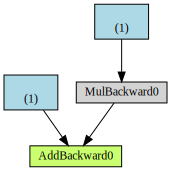

In [49]:
from torchviz import make_dot
make_dot(yhat)

The graph depicts the flow of the gradient computations. It is intended to be read from the bottom up.

The green box represents the starting point for the computation of gradients. The blue boxes are the parameters that we are training __and have autograd enabled__. We are missing the labels for the boxes (for now - we will see how to do this later when we define an actual model), but the top blue box represents $b$, and the blue box to the left represents $a$. 

The green box adds $a$ to the result of multiplying $b$ against the training tensor `dx_train_tensor`.

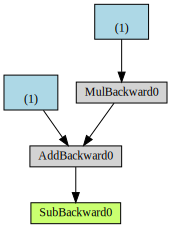

In [50]:
make_dot(error)

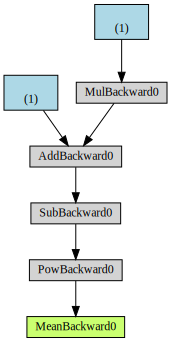

In [51]:
make_dot(loss)

We are currently manually updating our training parameters $a$ and $b$, much like what we did for the `numpy` implementation. Instead of doing it by hand, we can use a pytorch __optimizer__. Since we are performing a batch gradient descent we can use pytorch's [Stochastic Gradient Descent optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) in place of our code.

We need to initialize the optimizer with the names of our training parameters (which will be inserted into the pytorch dynamic computation graph) as well as our choice of the __learning rate__. Let's rewrite our previous program to explicitly use the SGD optimizer:

In [52]:
from torch.optim import SGD

torch.manual_seed(42)
pa = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
pb = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

optimizer = SGD([pa, pb], lr=lr)

for epoch in range(n_epochs):
    yhat = pa + pb * dx_train_tensor
    error = dy_train_tensor - yhat
    loss = (error ** 2).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
print(pa, pb)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


Notice that in place of the manual calculation of updated values for `pa` and `pb`, we call `optimizer.step()` instead, which does that operation for us. Zeroing of the gradients is still an explicit step, but we no longer need to specify `pa` and `pb`; the optimizer already knows that those are the parameters that it is optimizing for as they were initialized during construction of the `optimizer` object.

## pytorch models

Pytorch lets you organize your code into a Python class vs. defining everything at global scope. In return for this ceremony, it provides these benefits:

- a dictionary of all of the parameters used by the model (we'll see how this is useful in our graphs)
- 

In [53]:
from torch.nn import Module, Parameter

class ManualLinearRegression(Module):
    def __init__(self):
        super().__init__()
        self.pa = Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.pb = Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, dx):
        return self.pa + self.pb * dx

You can use the `model` as well as a set of helper functions like the `MSELoss` function to avoid implementing your own loss function.

In [54]:
from torch.nn import MSELoss

model = ManualLinearRegression().to(device)

lr = 1e-1
n_epochs = 1000

loss_fn = MSELoss(reduction='mean')
optimizer = SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    model.train()
    yhat = model(dx_train_tensor)
    loss = loss_fn(dy_train_tensor, yhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict()['pa'], model.state_dict()['pb'])

tensor([1.0235]) tensor([1.9690])


For the sake of the next few examples that follow, let's refactor all of the code that __uses the model__ into a function that we can reuse in our subsequent examples:

In [55]:
from torch.nn import MSELoss
from torch.optim import SGD

def train_linear_model(model, dx, dy):
    lr = 1e-1
    EPOCHS = 1000
    loss_fn = MSELoss(reduction='mean')
    optimizer = SGD(model.parameters(), lr=lr)
    
    for epoch in range(EPOCHS):
        model.train()
        yhat = model(dx)
        loss = loss_fn(dy, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    print(model.state_dict())

Now let's use `train_model` with our `ManualLinearRegression` object:

In [56]:
model = ManualLinearRegression().to(device)
train_linear_model(model, dx_train_tensor, dy_train_tensor)

OrderedDict([('pa', tensor([1.0235])), ('pb', tensor([1.9690]))])


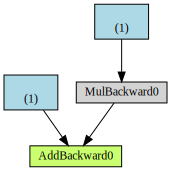

In [57]:
make_dot(model.forward(dx_train_tensor))

Of course, you don't even need to create a linear model, pytorch has a [Linear Model](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) already.

Let's use it by constructing a new class `LayeredLinearRegression` that simply delegates to the underlying `Linear` object:

In [58]:
from torch.nn import Linear

class LayeredLinearRegression(Module):
    def __init__(self):
        super().__init__()
        self.linear = Linear(1,1)
    
    def forward(self, dx):
        return self.linear(dx)

You can see that it automatically constructs parameters for the intercept and slope (weight and bias) with `requires_grad=True`:

In [59]:
model = LayeredLinearRegression()
[*model.parameters()]

[Parameter containing:
 tensor([[0.7388]], requires_grad=True), Parameter containing:
 tensor([0.1354], requires_grad=True)]

Now, let's replace our code from before that used `ManualLinearRegression` with our new `LayeredLinearRegression` type:

In [60]:
model = LayeredLinearRegression().to(device)
train_linear_model(model, dx_train_tensor, dy_train_tensor)

OrderedDict([('linear.weight', tensor([[1.9690]])), ('linear.bias', tensor([1.0235]))])


You can see that the weight ($b$) and bias ($a$) parameters are the same as we got from our `ManualLinearRegression` type.

But why define a separate `LayeredLinearRegression` class to simply forward computations to a `Linear` class? In neural networks, there are models that sequentially feed the output of one layer as the input to the next. pytorch provides a model type called [Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) model that does exactly this. 

Here is some code that constructs a new `Sequential` model and uses it to make the same set of predictions:

In [61]:
from torch.nn import Sequential

model = Sequential(Linear(1, 1)).to(device)
train_linear_model(model, dx_train_tensor, dy_train_tensor)

OrderedDict([('0.weight', tensor([[1.9690]])), ('0.bias', tensor([1.0235]))])


Note that the names of the parameters are a more generic `0.weight` and `0.bias` representing the underlying layer and the parameter name.

## Taking a step back to generalize

There is a set of operations that need to be completed during each training step. We can write a function `train_step` that is a further generalization of the `train_model` function that abstracts away the training loop in a way that lets us parameterize the __model__, the __loss function__, and the __optimizer__. Let's see what we can do here with the function `make_train_step_function` which accepts a model, a loss function and an optimizer as the parameters.

What is unclear to me right now is whether the `loss` object returned by the `loss_fn` is something that is generalizable. But I get the impression that this is a key abstraction within the pytorch framework to represent this concept.

In [62]:
def make_train_step_function(model, loss_fn, optimizer):
    def train_step(dx, dy):
        model.train()
        yhat = model(dx)
        loss = loss_fn(dy, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

Now let's rewrite our `train_linear_model` function to take advantage of the `make_train_step_function` abstraction:

In [63]:
def train_linear_model(model, dx, dy):
    lr = 1e-1
    EPOCHS = 1000
    loss_fn = MSELoss(reduction='mean')
    optimizer = SGD(model.parameters(), lr=lr)
    train_step = make_train_step_function(model, loss_fn, optimizer)
    losses = []
    
    for epoch in range(EPOCHS):
        loss = train_step(dx, dy)
        losses.append(loss)
    
    print(model.state_dict())

In [64]:
model = Sequential(Linear(1, 1)).to(device)
train_linear_model(model, dx_train_tensor, dy_train_tensor)

OrderedDict([('0.weight', tensor([[1.9690]])), ('0.bias', tensor([1.0235]))])


## Managing the data for our models

Pytorch provides a number of helper classes and methods for dealing with data. Data isn't as simple as just a couple of arrays as we initially created at the start of this tutorial. Rather, there are operations like splitting data into training and validation datasets and splitting each one of those into a set of mini-batches that can be downloaded into your GPU's RAM (because the entire dataset won't fit at once for anything significant).

A [Dataset](https://pytorch.org/docs/stable/data.html) is a base type that you can use for definining your own custom dataset. Below is a simple implementation of a `CustomDataset` that stores all data in memory:

In [65]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.dx = x_tensor
        self.dy = y_tensor
        
    def __getitem__(self, index):
        return (self.dx[index], self.dy[index])
    
    def __len__(self):
        return len(self.dx)

Now let's use `CustomDataset` to load our training tensors and display some data:

In [66]:
train_data = CustomDataset(dx_train_tensor, dy_train_tensor)
train_data[:5]

(tensor([[0.7713],
         [0.0636],
         [0.8631],
         [0.0254],
         [0.7320]]), tensor([[2.4745],
         [1.1928],
         [2.9128],
         [1.0785],
         [2.4732]]))

You can get the same functionality if you use the built-in `TensorDataset` class:

In [67]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(dx_train_tensor, dy_train_tensor)
train_data[:5]

(tensor([[0.7713],
         [0.0636],
         [0.8631],
         [0.0254],
         [0.7320]]), tensor([[2.4745],
         [1.1928],
         [2.9128],
         [1.0785],
         [2.4732]]))

The real value provided by representing your data as a `Dataset` comes when you combine it with a `DataLoader`. This type lets you easily implement __mini-batch gradient descent__ where only a subset of the dataset can fit in your GPU RAM at a time.

The `train_loader` object created below behaves like a Python iterator, so we can use the `next` function to retrieve the next mini-batch containing 16 values:

In [68]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
next(iter(train_loader))

[tensor([[0.2713],
         [0.2809],
         [0.3252],
         [0.1834],
         [0.7713],
         [0.1705],
         [0.3110],
         [0.7722],
         [0.7081],
         [0.4938],
         [0.8872],
         [0.7320],
         [0.2588],
         [0.0344],
         [0.5427],
         [0.2921]]), tensor([[1.5105],
         [1.5846],
         [1.7291],
         [1.4637],
         [2.4745],
         [1.3585],
         [1.5245],
         [2.4208],
         [2.3660],
         [1.9060],
         [2.8708],
         [2.4732],
         [1.5967],
         [1.1831],
         [2.2161],
         [1.5848]])]

Finally we can implement mini-batch stochastic gradient descent.

In [69]:
losses = []
train_step = make_train_step_function(model, loss_fn, optimizer)

for epoch in range(1000):
    for dx_batch, dy_batch in train_loader:
        # In the case of GPU machines, we need to move the mini-batch to
        # the device RAM first before we can train
        dx_batch = dx_batch.to(device)
        dy_batch = dy_batch.to(device)
        
        loss = train_step(dx_batch, dy_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]])), ('0.bias', tensor([1.0235]))])


## Validating our model

Up until now, we've been looking at only training our model, not validating the results of the model against the validation dataset (perhaps I should go back and do this manually as well both from scratch and using numpy).

In [70]:
from torch.utils.data.dataset import random_split

dx_tensor = torch.from_numpy(dx).float()
dy_tensor = torch.from_numpy(dy).float()

dataset = TensorDataset(dx_tensor, dy_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

With our data prepared, next let's write both a training and a validation loop for our mini-batches:

In [71]:
train_losses = []
val_losses = []
train_step = make_train_step_function(model, loss_fn, optimizer)

for epoch in range(1000):
    for dx_batch, dy_batch in train_loader:
        dx_batch = dx_batch.to(device)
        dy_batch = dy_batch.to(device)
        loss = train_step(dx_batch, dy_batch)
        train_losses.append(loss)
        
    with torch.no_grad():
        for dx_val, dy_val in val_loader:
            dx_val = dx_val.to(device)
            dy_val = dy_val.to(device)
            model.eval()
            yhat = model(dx_val)
            val_loss = loss_fn(dy_val, yhat)
            val_losses.append(val_loss.item())
            
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]])), ('0.bias', tensor([1.0235]))])


__BUT__ I don't know how to visualize how well the validation losses?